In [79]:
import os
import glob
import torch
import matplotlib.pyplot as plt
import random
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
from collections import defaultdict

In [80]:
from PIL import Image
from torch.utils.data import Dataset

class ImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.classes, self.class_to_idx = self._find_classes()
        self.samples = self._make_dataset()

    def _find_classes(self):
        classes = [d.name for d in os.scandir(self.root) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls: int(cls) for i, cls in enumerate(classes)}
        return classes, class_to_idx

    def _make_dataset(self):
        samples = []
        for target_class in self.classes:
            class_dir = os.path.join(self.root, target_class)
            if not os.path.isdir(class_dir):
                continue

            for root, _, fnames in sorted(os.walk(class_dir)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = (path, self.class_to_idx[target_class])
                    samples.append(item)
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, target = self.samples[index]
        image = Image.open(path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, target

In [81]:
class CustomTrainDataset(Dataset):
    def __init__(self, original_dataset, additional_samples=None):
        self.original_dataset = original_dataset
        self.additional_samples = additional_samples if additional_samples else []
    
    def __len__(self):
        return len(self.original_dataset) + len(self.additional_samples)

    def __getitem__(self, index):
        if index < len(self.original_dataset):
            return self.original_dataset[index]
        else:
            additional_index = index - len(self.original_dataset)
            return self.additional_samples[additional_index]

In [82]:
class DataHandler:
    def __init__(self, root='../../data/raw/train', ratio=0.1, transform=None):
        self.root = root
        self.transform = transform
        self.ratio = ratio
        
    def get_classes(self, phase):
        all_classes = []
        for i in glob.glob(os.path.join(self.root,f"phase_{str(phase)}/*")):
            name = i.split("/")[-1]
            all_classes.append((name,int(name)))
        return dict(all_classes)

    def get_one_phase_dataset(self, phase):
        dataset = ImageFolder(root=os.path.join(self.root,f'phase_{str(phase)}'), transform=self.transform)
        total_samples = len(dataset)
        test_size = int(self.ratio * total_samples)
        train_size = total_samples - test_size
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
        return train_dataset, test_dataset

    def update_one_phase_dateset(self, phase):
        train_dataset, test_dataset = self.get_one_phase_dataset(phase)
        if phase > 1:
            additional_samples = []
            for previous_phase in range(1,phase):
                previous_train_dataset, previous_test_dataset = self.get_one_phase_dataset(previous_phase)
                test_dataset = ConcatDataset([test_dataset, previous_test_dataset])
                track = defaultdict(int)
                for i, (sample, label) in enumerate(previous_train_dataset):
                    if track[label] == 5:
                        continue
                    additional_samples.append((sample, label))
                    track[label]+=1

            train_dataset = CustomTrainDataset(train_dataset, additional_samples)
        return train_dataset, test_dataset
    

In [83]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

265


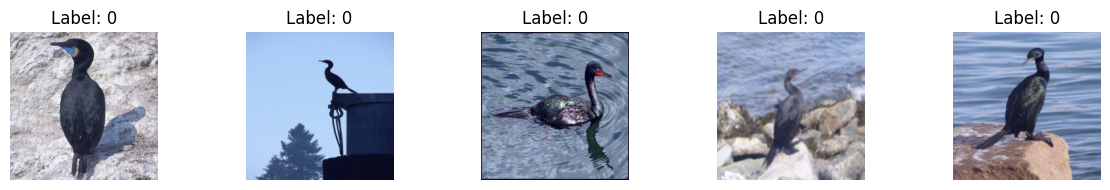

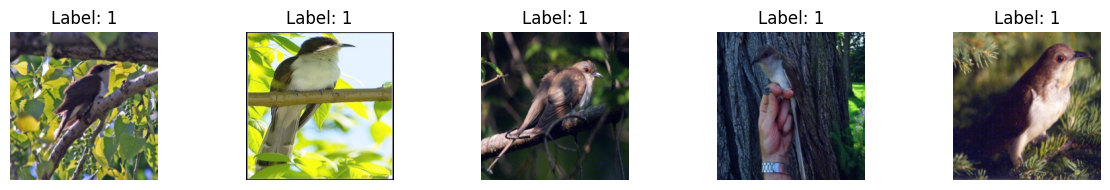

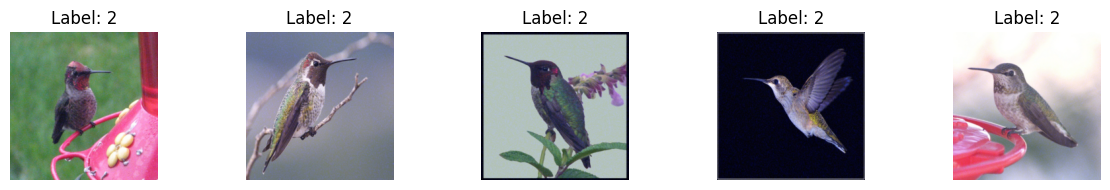

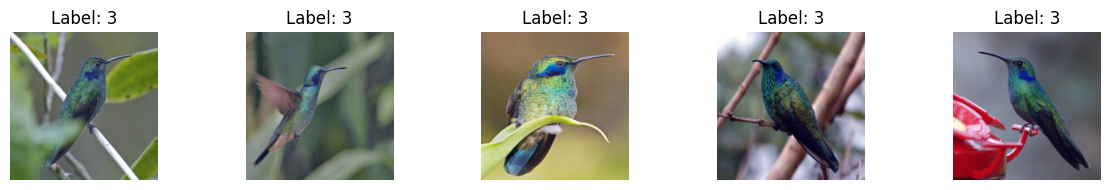

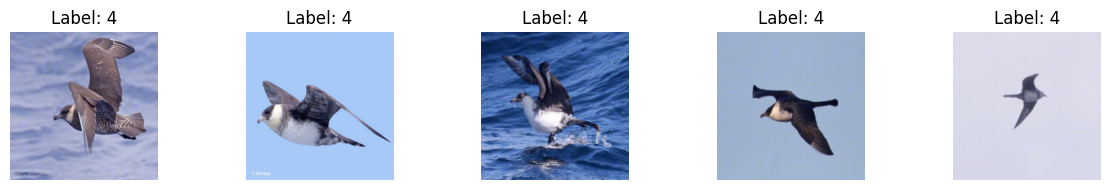

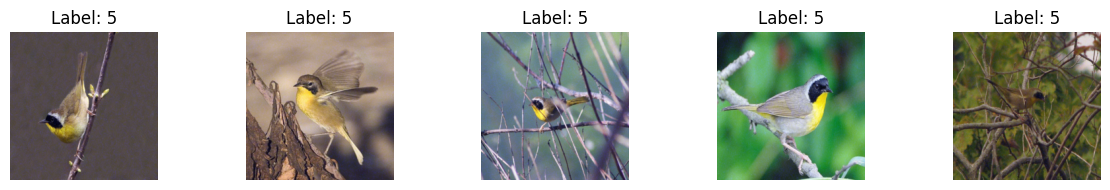

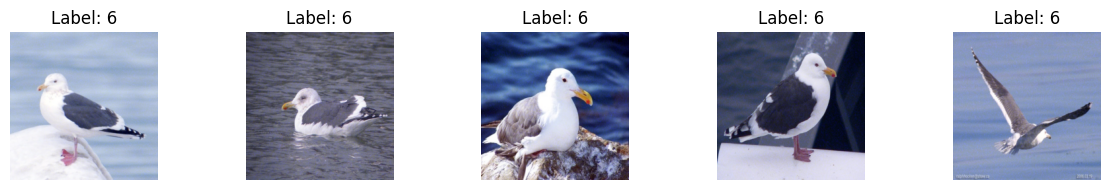

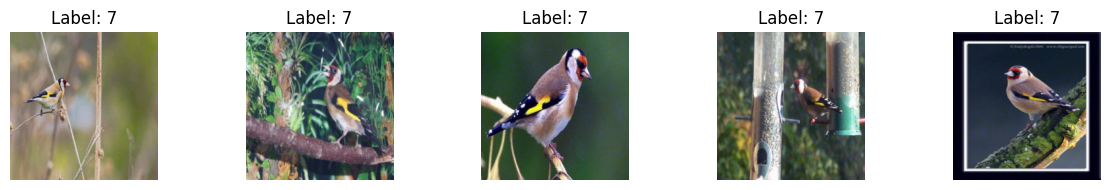

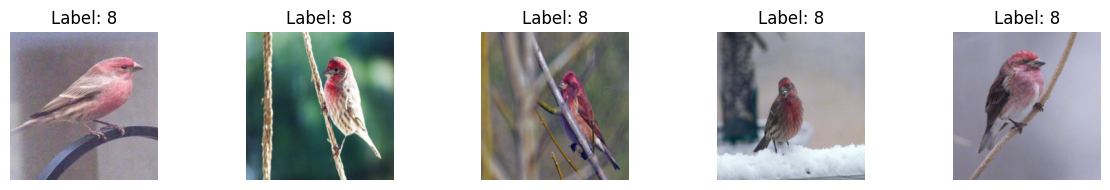

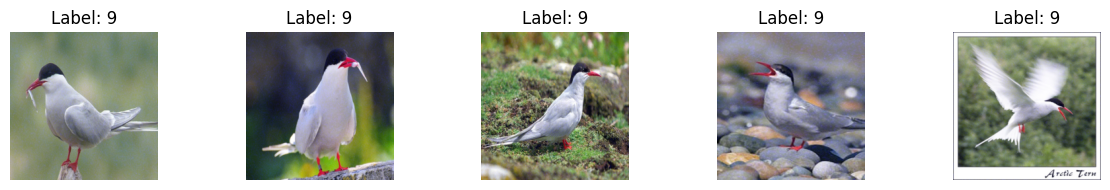

In [84]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_images_per_label(phase=1, transform=transform, num_images_per_label=5):
    datahandler = DataHandler(transform=transform)
    dataset, _ = datahandler.update_one_phase_dateset(phase)
    print(len(dataset))

    unique_labels = list(range(phase*10))
    images_per_label = {label: [] for label in unique_labels}

    for index in range(len(dataset)):
        image, label = dataset[index]
        if len(images_per_label[label]) < num_images_per_label:
            images_per_label[label].append(image)

    for label, images in images_per_label.items():
        plt.figure(figsize=(12, 2))
        for i, image in enumerate(images):
            plt.subplot(1, num_images_per_label, i + 1)
            plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))  
            plt.title(f"Label: {label}")
            plt.axis('off')
        plt.tight_layout()
    plt.show()
    
visualize_images_per_label()
